<a href="https://colab.research.google.com/github/sudo-Oliver/Predictive-Analytics-Private/blob/main/notebooks/LSTM%20Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Data loading and Preprocessing**
1. Library Setup and GPU Configuration:
- Import required Python libraries for data analysis and deep learning
- Configure PyTorch for Mac GPU (MPS) usage
- Verify device availability and settings

2. Data Loading and Initial Processing:
- Load preprocessed sensor data from parquet file
- Implement fallback to Google Drive download if file not present locally
- Basic data validation and shape verification

3.  Data Cleaning and Transformation:
- Convert Unix timestamps to datetime format
- Sort data by household ID and timestamp
- Remove unnecessary sensor and room-related columns
- Convert energy consumption units from Wh to kWh
- Handle negative gas consumption values

4. Feature Engineering:
- Create cyclical time features (hour_sin, hour_cos)
- Generate lag features for both electricity and gas consumption (1-3 hours)
- Calculate rolling mean features (3h and 7h windows)
- Handle missing values through forward and backward fill

5. Correlation Analysis:
- Calculate complete correlation matrix
- Focus on correlations with target variables (electricity and gas consumption)
- Sort and display correlations by strength
- Visualize relationships between features and target variables


In [2]:
# Standard library imports
import os
from pathlib import Path

# Data manipulation and analysis
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import dump, load

# Deep learning frameworks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from tqdm.auto import tqdm
from tabulate import tabulate

# File download
import gdown

In [3]:
# Verify PyTorch version and MPS availability
print("PyTorch version:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())

# Configure device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Metal GPU device")
else:
    device = torch.device("cpu")
    print("Running on CPU")

# Verify current device
print("Current device:", device)

PyTorch version: 2.6.0.dev20241112
MPS available: True
MPS built: True
Using Metal GPU device
Current device: mps


In [4]:
def load_processed_data():
    #Load preprocessed sensor data with fallback to Drive download
    file_id = "1KHQCVfwTxm5bjjITS8WMm9P3M12ETVsR"
    
    download_path = Path('data/processed')
    download_path.mkdir(parents=True, exist_ok=True)
    file_path = download_path / 'final_processed_data3.parquet'
    
    if not file_path.exists():
        print("Downloading from Google Drive...")
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, str(file_path), quiet=False)
    
    if file_path.exists():
        df = pd.read_parquet(file_path)
        print(f"Data loaded successfully: {df.shape} rows")
        return df
    else:
        raise FileNotFoundError("Could not load or download data file")

def clean_data(df):
    # Convert Unix timestamp to datetime
    if 'timestamp_local' in df.columns:
        df['timestamp_local'] = pd.to_datetime(df['timestamp_local'], unit='ms')
        # Sort before setting index
        df = df.sort_values(by=['homeid', 'timestamp_local'])
        # Set index
        df.set_index('timestamp_local', inplace=True)
    
    # Remove unnecessary columns
    columns_to_drop = [
        'sensorid', 'median_temperature', '_room',
        'sensorid_room', 'measured_entity',
        'sensorid_electric', 'sensorid_gas'
    ]
    
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # First rename consumption columns from Wh to kWh
    df = df.rename(columns={
        'electric_total_consumption_Wh': 'electric_total_consumption_kWh',
        'gas_total_consumption_Wh': 'gas_total_consumption_kWh'
    })
    
    # Replace negative values with 0 in gas columns
    gas_columns = [
        'gas_mean_consumption', 
        'gas_min_consumption', 
        'gas_max_consumption',
        'gas_median_consumption', 
        'gas_total_consumption_kWh'
    ]
    
    # Use clip to replace negative values with 0 (more efficient than applymap)
    df[gas_columns] = df[gas_columns].clip(lower=0)
    
    return df

def create_features(df, df_original):
    """Create time-based and lag features"""
    # Verify datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have DatetimeIndex")
    
    # Cyclical time features
    df['hour'] = df.index.hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Lag features using original values
    for lag in range(1, 4):
        df[f'electric_lag_{lag}'] = df_original.groupby('homeid')['electric_total_consumption_kWh'].shift(lag)
        df[f'gas_lag_{lag}'] = df_original.groupby('homeid')['gas_total_consumption_kWh'].shift(lag)
    
    # Rolling means using original values
    df['electric_rolling_mean_3h'] = df_original.groupby('homeid')['electric_total_consumption_kWh'].rolling(window=3).mean().reset_index(0, drop=True)
    df['electric_rolling_mean_7h'] = df_original.groupby('homeid')['electric_total_consumption_kWh'].rolling(window=7).mean().reset_index(0, drop=True)
    df['gas_rolling_mean_3h'] = df_original.groupby('homeid')['gas_total_consumption_kWh'].rolling(window=3).mean().reset_index(0, drop=True)
    df['gas_rolling_mean_7h'] = df_original.groupby('homeid')['gas_total_consumption_kWh'].rolling(window=7).mean().reset_index(0, drop=True)
    
    return df

# Main preprocessing pipeline
print("Loading data...")
df = load_processed_data()

print("\nCleaning data...")
df_clean = clean_data(df.copy())
df_original = df_clean.copy()  # Keep unmodified copy for feature creation

print("\nCreating features...")
df_clean = create_features(df_clean, df_original)

print("Handling missing values...")
df_clean = df_clean.ffill().bfill()

# Verify data
print("\nData shape after preprocessing:", df_clean.shape)
print("Index type:", type(df_clean.index))
print("Feature columns:", df_clean.columns.tolist())

df_clean.head()

Loading data...
Data loaded successfully: (1641653, 23) rows

Cleaning data...

Creating features...
Handling missing values...

Data shape after preprocessing: (1641653, 28)
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Feature columns: ['homeid', 'electric_min_consumption', 'electric_max_consumption', 'std_consumption', 'electric_median_consumption', 'electric_total_consumption_kWh', 'gas_mean_consumption', 'gas_min_consumption', 'gas_max_consumption', 'gas_median_consumption', 'gas_total_consumption_kWh', 'median_value', 'roomid', 'income_band_mid', 'education_map', 'hour', 'hour_sin', 'hour_cos', 'electric_lag_1', 'gas_lag_1', 'electric_lag_2', 'gas_lag_2', 'electric_lag_3', 'gas_lag_3', 'electric_rolling_mean_3h', 'electric_rolling_mean_7h', 'gas_rolling_mean_3h', 'gas_rolling_mean_7h']


,homeid,electric_min_consumption,electric_max_consumption,std_consumption,electric_median_consumption,electric_total_consumption_kWh,gas_mean_consumption,gas_min_consumption,gas_max_consumption,gas_median_consumption,...,electric_lag_1,gas_lag_1,electric_lag_2,gas_lag_2,electric_lag_3,gas_lag_3,electric_rolling_mean_3h,electric_rolling_mean_7h,gas_rolling_mean_3h,gas_rolling_mean_7h
timestamp_local,,,,,,,,,,,,,,,,,,,,,
2016-09-20 09:00:00,47,0.069000,0.335000,0.033905,0.194000,0.179807,0.112,0.112,0.112,0.112,...,0.179807,0.224,0.179807,0.224,0.179807,0.224,0.176690,0.170457,0.210,0.182
2016-09-20 10:00:00,47,0.068875,0.458375,0.035875,0.187625,0.176690,0.112,0.112,0.112,0.112,...,0.179807,0.224,0.179807,0.224,0.179807,0.224,0.176690,0.170457,0.210,0.182
2016-09-20 11:00:00,47,0.068750,0.581750,0.037846,0.181250,0.173574,0.112,0.112,0.112,0.112,...,0.176690,0.210,0.179807,0.224,0.179807,0.224,0.176690,0.170457,0.210,0.182
2016-09-20 12:00:00,47,0.068625,0.705125,0.039817,0.174875,0.170457,0.112,0.112,0.112,0.112,...,0.173574,0.196,0.176690,0.210,0.179807,0.224,0.173574,0.170457,0.196,0.182
2016-09-20 13:00:00,47,0.068500,0.828500,0.041788,0.168500,0.167340,0.112,0.112,0.112,0.112,...,0.170457,0.182,0.173574,0.196,0.176690,0.210,0.170457,0.170457,0.182,0.182


In [5]:
# Vollständige Korrelation mit allen spalten berechnen
correlation_matrix_all = df_clean.corr()

# Korrelation der Features mit den Zielvariablen (Strom und Gasverbtauch)
correlation_target_all = correlation_matrix_all[['electric_total_consumption_kWh', 'gas_total_consumption_kWh']]

# Sortieren nach Stärke der Korrelation
correlation_target_all_sorted = correlation_target_all.abs().sort_values(by=['electric_total_consumption_kWh', 'gas_total_consumption_kWh'], ascending=False)

# Korrelationsergebnisse anzeigen
print("Full Feature Correlation:")
display(correlation_target_all_sorted)

Full Feature Correlation:


,electric_total_consumption_kWh,gas_total_consumption_kWh
electric_total_consumption_kWh,1.000000,0.032211
electric_rolling_mean_3h,0.910031,0.033895
electric_lag_1,0.815291,0.031146
electric_median_consumption,0.803903,0.025041
electric_rolling_mean_7h,0.795197,0.035802
std_consumption,0.775032,0.024053
electric_lag_2,0.705972,0.030551
electric_max_consumption,0.693017,0.042800
electric_lag_3,0.629546,0.030036
electric_min_consumption,0.516674,0.039670


### 2.Feature Engineering & Data Scaling ### 
- Directory Setup: Create directory for scalers
- Data Backup: Store original unscaled data
- Time Features: Add cyclical hour encoding
- Lag Features: Create time-lagged features (1-3 hours)
- Rolling Means: Calculate 3h and 7h rolling averages
- Missing Values: Handle using forward and backward fill
- Scaling Setup: Initialize StandardScalers
- Feature Scaling: Scale features and target variables
- Save Artifacts: Store scalers and parameters
- Verification: Check scaling results

In [6]:
# Create scalers directory
Path('scalers').mkdir(parents=True, exist_ok=True)

# Store original unscaled data
df_original = df_clean.copy()

# Extract hour and create cyclical features
df_clean['hour'] = df_clean.index.hour
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

# Create lag features using original values
for lag in range(1, 4):
    df_clean[f'electric_lag_{lag}'] = df_original.groupby('homeid')['electric_total_consumption_kWh'].shift(lag)
    df_clean[f'gas_lag_{lag}'] = df_original.groupby('homeid')['gas_total_consumption_kWh'].shift(lag)

# Create rolling means using original values
df_clean['electric_rolling_mean_3h'] = df_original.groupby('homeid')['electric_total_consumption_kWh'].rolling(window=3).mean().reset_index(0, drop=True)
df_clean['electric_rolling_mean_7h'] = df_original.groupby('homeid')['electric_total_consumption_kWh'].rolling(window=7).mean().reset_index(0, drop=True)
df_clean['gas_rolling_mean_3h'] = df_original.groupby('homeid')['gas_total_consumption_kWh'].rolling(window=3).mean().reset_index(0, drop=True)
df_clean['gas_rolling_mean_7h'] = df_original.groupby('homeid')['gas_total_consumption_kWh'].rolling(window=7).mean().reset_index(0, drop=True)

# Handle missing values
df_clean = df_clean.ffill().bfill()

# Get original min/max values from unscaled data
scaling_params = {
    "electric_mean": df_original["electric_total_consumption_kWh"].mean(),
    "electric_std": df_original["electric_total_consumption_kWh"].std(),
    "gas_mean": df_original["gas_total_consumption_kWh"].mean(),
    "gas_std": df_original["gas_total_consumption_kWh"].std(),
}

print("\nOriginal values before scaling:")
for key, value in scaling_params.items():
    print(f"{key}: {value:.4f}")

# Initialize scalers
scaler_features = StandardScaler()
scaler_electric = StandardScaler()
scaler_gas = StandardScaler()

# Scale features (excluding target variables)
feature_columns = [col for col in df_clean.columns if col not in [
    'electric_total_consumption_kWh', 
    'gas_total_consumption_kWh', 
    'homeid', 
    'hour'
]]

print(feature_columns)
print(len(feature_columns))

df_clean[feature_columns] = scaler_features.fit_transform(df_clean[feature_columns])

# Scale target variables using original data
df_clean['electric_total_consumption_kWh'] = scaler_electric.fit_transform(
    df_original[['electric_total_consumption_kWh']]
)
df_clean['gas_total_consumption_kWh'] = scaler_gas.fit_transform(
    df_original[['gas_total_consumption_kWh']]
)

# Save scalers
dump(scaler_features, 'scalers/scaler_features.pkl')
dump(df_clean['electric_total_consumption_kWh'], 'scalers/scaler_electric.pkl')
dump(df_clean['gas_total_consumption_kWh'], 'scalers/scaler_gas.pkl')
dump(scaling_params, 'scalers/scaling_params.pkl')  # Save mean and std for later inverse transformation

# Verify scaling with mean and standard deviation
print("\nVerifying scalers:")
for name, scaler in [('Electric', scaler_electric), ('Gas', scaler_gas)]:
    print(f"\n{name} scaler:")
    print(f"Mean: {scaler.mean_[0]:.6f}")
    print(f"Standard deviation: {scaler.scale_[0]:.6f}")

# Save preprocessed data
# df_clean.to_parquet('lstm_preprocessed_data.parquet')


Original values before scaling:
electric_mean: 0.4986
electric_std: 0.4750
gas_mean: 13.3070
gas_std: 98.2659
['electric_min_consumption', 'electric_max_consumption', 'std_consumption', 'electric_median_consumption', 'gas_mean_consumption', 'gas_min_consumption', 'gas_max_consumption', 'gas_median_consumption', 'median_value', 'roomid', 'income_band_mid', 'education_map', 'hour_sin', 'hour_cos', 'electric_lag_1', 'gas_lag_1', 'electric_lag_2', 'gas_lag_2', 'electric_lag_3', 'gas_lag_3', 'electric_rolling_mean_3h', 'electric_rolling_mean_7h', 'gas_rolling_mean_3h', 'gas_rolling_mean_7h']
24

Verifying scalers:

Electric scaler:
Mean: 0.498573
Standard deviation: 0.475012

Gas scaler:
Mean: 13.307014
Standard deviation: 98.265865


### 3. Time Series Data Preparation for LSTM Models ###
- Parameter Definition: Set sequence length and identify feature columns
- Memory Management: Create memory-mapped arrays for efficient data handling
- Data Processing: Implement chunk-based processing for large datasets
- Sequence Creation: Generate time series sequences for LSTM input
- Data Split: Create train-test sets while maintaining temporal order
- Coverage Analysis: Track household representation in datasets
- Shape Verification: Confirm proper data structuring

In [7]:
# Define parameters and columns
time_steps = 90

# Features and target definition (Strom und Gas)
feature_columns = [col for col in df_clean.columns if col not in ['electric_total_consumption_kWh', 'gas_total_consumption_kWh', 'homeid', 'roomid']]
target_column_electric = 'electric_total_consumption_kWh'
target_column_gas = 'gas_total_consumption_kWh'

def create_memmap_array(shape, filename, dtype='float32'):
    path = Path('temp_arrays')
    path.mkdir(exist_ok=True)
    return np.memmap(path / filename, dtype=dtype, mode='w+', shape=shape)

def process_data_efficiently(df_clean, target_column, feature_columns, time_steps, prefix):
    total_sequences = len(df_clean) - time_steps
    n_features = len(feature_columns)
    
    # Create memory-mapped arrays
    X = create_memmap_array((total_sequences, time_steps, n_features), f'{prefix}_X.mmap')
    y = create_memmap_array((total_sequences,), f'{prefix}_y.mmap')
    
    # Process in smaller chunks
    chunk_size = 500
    feature_data = df_clean[feature_columns].values
    target_data = df_clean[target_column].values
    
    print(f"Processing {prefix} data...")
    for chunk_start in range(0, total_sequences, chunk_size):
        chunk_end = min(chunk_start + chunk_size, total_sequences)
        
        for i in range(chunk_start, chunk_end):
            X[i] = feature_data[i:i + time_steps]
            y[i] = target_data[i + time_steps]
            
        if chunk_start % (chunk_size * 10) == 0:
            print(f"Progress: {chunk_start/total_sequences*100:.1f}%")
    
    return X, y

# Process gas data
time_steps = 90
feature_columns = [col for col in df_clean.columns if col not in 
                  ['electric_total_consumption_kWh', 'gas_total_consumption_kWh', 'homeid', 'roomid']]



# Process gas data
X_gas, y_gas = process_data_efficiently(
    df_clean,
    'gas_total_consumption_kWh',
    feature_columns,
    time_steps,
    'gas'
)

# Split datasets
X_train_gas, X_test_gas, y_train_gas, y_test_gas = train_test_split(
    X_gas, y_gas, test_size=0.2, shuffle=False
)

# Check how many households are included in the training and test set
train_households_gas = df_clean.loc[df_clean.index[-len(y_train_gas):], 'homeid'].nunique()
test_households_gas = df_clean.loc[df_clean.index[-len(y_test_gas):], 'homeid'].nunique()

print(f" Haushalte im Training (Gas): {train_households_gas}")
print(f" Haushalte im Test (Gas): {test_households_gas}")
# Needs to be further investigated
print(f" Verlust an Haushalten: {254 - test_households_gas}")





# Show shapes of the data
train_test_summary = {
    'X_train_gas': X_train_gas.shape,
    'X_test_gas': X_test_gas.shape,
}
train_test_summary

Processing gas data...
Progress: 0.0%
Progress: 0.3%
Progress: 0.6%
Progress: 0.9%
Progress: 1.2%
Progress: 1.5%
Progress: 1.8%
Progress: 2.1%
Progress: 2.4%
Progress: 2.7%
Progress: 3.0%
Progress: 3.4%
Progress: 3.7%
Progress: 4.0%
Progress: 4.3%
Progress: 4.6%
Progress: 4.9%
Progress: 5.2%
Progress: 5.5%
Progress: 5.8%
Progress: 6.1%
Progress: 6.4%
Progress: 6.7%
Progress: 7.0%
Progress: 7.3%
Progress: 7.6%
Progress: 7.9%
Progress: 8.2%
Progress: 8.5%
Progress: 8.8%
Progress: 9.1%
Progress: 9.4%
Progress: 9.7%
Progress: 10.1%
Progress: 10.4%
Progress: 10.7%
Progress: 11.0%
Progress: 11.3%
Progress: 11.6%
Progress: 11.9%
Progress: 12.2%
Progress: 12.5%
Progress: 12.8%
Progress: 13.1%
Progress: 13.4%
Progress: 13.7%
Progress: 14.0%
Progress: 14.3%
Progress: 14.6%
Progress: 14.9%
Progress: 15.2%
Progress: 15.5%
Progress: 15.8%
Progress: 16.1%
Progress: 16.4%
Progress: 16.8%
Progress: 17.1%
Progress: 17.4%
Progress: 17.7%
Progress: 18.0%
Progress: 18.3%
Progress: 18.6%
Progress: 18.9%
Pr

{'X_train_gas': (1313250, 90, 24), 'X_test_gas': (328313, 90, 24)}

### 4. LSTM Model Implementation and Training Pipeline ###
- LSTM Architecture: Custom LSTM model with configurable layers and dropout
- Device Management: MPS (Metal Performance Shaders) support for Mac
- Data Handling: Efficient data loading and batch processing
- Training Features: Early stopping, Model checkpointing, Progress monitoring and Loss tracking
- Optimization: Adam optimizer with configurable learning rate

**The LSTM Architecture**

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Add dropout parameter to LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0  # Only apply dropout with multiple layers
        )
        
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

**The LSTM Training**

In [ ]:
# Check and configure MPS device for M2 Mac
has_mps = torch.backends.mps.is_available()
if has_mps:
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("MPS device not found, using CPU")

# Improved data preparation with explicit float32
def prepare_data_for_training(X, y, batch_size=16):
    X_tensor = torch.FloatTensor(X).to(torch.float32)
    y_tensor = torch.FloatTensor(y).reshape(-1, 1).to(torch.float32)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Early stopping handler
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Improved training function with early stopping
def train_model(model, train_loader, model_name, num_epochs=10):
    checkpoint_dir = 'checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    early_stopping = EarlyStopping(patience=2)
    best_loss = float('inf')

    epoch_pbar = tqdm(range(num_epochs), desc=f'Training {model_name}', position=0)
    
    for epoch in epoch_pbar:
        model.train()
        running_loss = 0.0
        
        batch_pbar = tqdm(train_loader, 
                         desc=f'Epoch {epoch+1}/{num_epochs}',
                         leave=False, 
                         position=1)
        
        for inputs, targets in batch_pbar:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            batch_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        epoch_loss = running_loss / len(train_loader)
        epoch_pbar.set_postfix({'loss': f'{epoch_loss:.4f}'})

        # Save checkpoint for each epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
        }, os.path.join(checkpoint_dir, f'{model_name}_epoch{epoch+1}.pt'))
        print(f"\nSaved checkpoint for epoch {epoch+1}")

        # Save best model separately
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, os.path.join(checkpoint_dir, f'{model_name}_best.pt'))
            print(f"New best model saved! Loss: {best_loss:.4f}")

        # Early stopping check
        early_stopping(epoch_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    print(f"\n{model_name} training complete! Best loss: {best_loss:.4f}")
    return model

# Helper function to load trained models
def load_trained_model(model, model_name):
    checkpoint_path = os.path.join('checkpoints', f'{model_name}_best.pt')
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded best model from epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4f}")
    return model

# Training pipeline
train_loader_gas = prepare_data_for_training(X_train_gas, y_train_gas)


print("\nTraining Gas Model...")
model_gas = LSTMModel(input_size=len(feature_columns), 
                      hidden_size=32, 
                      num_layers=2, 
                      output_size=1).to(device)
model_gas = train_model(model_gas, train_loader_gas, "gas")

### 5. Model Evaluation and Visualization Pipeline ###
- Core Functions and Utilities
- Model Loading and Evaluation
- Visualization Functions
- Main Evaluation Pipeline

In [10]:
# Device setup with error handling
def get_device():
    try:
        if torch.backends.mps.is_available():
            return torch.device("mps")
        else:
            print("MPS not available, falling back to CPU")
            return torch.device("cpu")
    except:
        print("Error checking MPS, falling back to CPU")
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

def calculate_metrics(predictions, actuals, model_name=None):
    try:
        # Basic metrics
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mse = mean_squared_error(actuals, predictions)
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)
        
        # MAPE calculation with protection against small values
        mask = np.abs(actuals) > np.percentile(np.abs(actuals), 5)  # Werte unter dem 5. Perzentil filtern
        if np.any(mask):
            mape = np.mean(np.abs((actuals[mask] - predictions[mask]) / 
                                 np.maximum(actuals[mask], 1e-10))) * 100
        else:
            mape = np.nan
            print(f" Warning: No valid values for MAPE calculation in {model_name}")
        
        # SMAPE calculation (more robust against zero/small values)
        denominator = (np.abs(actuals) + np.abs(predictions))
        mask_smape = denominator >= 1e-10
        if np.any(mask_smape):
            smape = 100 * np.mean(2 * np.abs(predictions[mask_smape] - actuals[mask_smape]) / 
                                denominator[mask_smape])
        else:
            smape = np.nan
        
        # Baseline comparison
        baseline_mse = mean_squared_error(actuals, np.full_like(actuals, np.mean(actuals)))
        if mse > baseline_mse and model_name:
            print(f" Warning: {model_name} MSE ({mse:.2f}) is higher than baseline MSE ({baseline_mse:.2f})")
        
        metrics = {
            'RMSE': float(f"{rmse:.4f}"),
            'MSE': float(f"{mse:.4f}"),
            'MAE': float(f"{mae:.4f}"),
            'R2': float(f"{r2:.4f}"),
            'MAPE': float(f"{mape:.4f}") if not np.isnan(mape) else np.nan,
            'SMAPE': float(f"{smape:.4f}") if not np.isnan(smape) else np.nan
        }
        
        # Print additional insights
        if model_name:
            print(f"\nDetailed metrics for {model_name}:")
            print(f"- MAPE: {metrics['MAPE']:.2f}% (traditional)")
            print(f"- SMAPE: {metrics['SMAPE']:.2f}% (symmetric)")
            print(f"- Values near zero: {(~mask).sum()} of {len(actuals)}")
        
        return metrics
        
    except Exception as e:
        print(f" Error calculating metrics: {e}")
        return None
# Inverse scaling with error handling
def inverse_scale_predictions(predictions, actuals, scaler):
    try:
        pred_orig = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        act_orig = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()
        return pred_orig, act_orig
    except Exception as e:
        print(f"Error during inverse scaling: {e}")
        return predictions.flatten(), actuals.flatten()

# Enhanced model evaluation with additional visualizations
def evaluate_model(model, model_name, test_loader, scaler):
    print(f"\nEvaluating {model_name} model...")
    
    model.eval()
    predictions, actuals = [], []
    
    # Prediction loop with error handling
    with torch.no_grad():
        try:
            for inputs, targets in tqdm(test_loader, desc="Making predictions"):
                inputs = inputs.to(device)
                outputs = model(inputs)
                predictions.append(outputs.cpu().numpy())
                actuals.append(targets.cpu().numpy())
        except Exception as e:
            print(f"Error during prediction: {e}")
            return None, None, None

    # Process results
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    print(f"Predictions:: {predictions}")
    print(f"Ground Truth:: {actuals}")
    
    # Inverse scaling
    # predictions, actuals = inverse_scale_predictions(predictions, actuals, scaler)
    
    # Calculate metrics
    metrics = calculate_metrics(predictions, actuals)
    
    # Create formatted metrics DataFrame
    metrics_df = pd.DataFrame({
        'Metric': list(metrics.keys()),
        'Value': [f"{v:.4f}" for v in metrics.values()]
    })
    
    # Print results
    print(f"\nMetrics for {model_name} Gas Consumption:")
    print(tabulate(metrics_df, headers='keys', tablefmt='pipe', showindex=False))
    
    return predictions, actuals, metrics_df

Using device: mps


In [11]:
def load_trained_model(model, model_name):
    try:
        checkpoint_path = os.path.join('checkpoints', f'{model_name}_best.pt')
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f" Loaded best model for {model_name} from epoch {checkpoint['epoch']}")
        else:
            print(f" No checkpoint found for {model_name}, using untrained model")
        return model
    except Exception as e:
        print(f" Error loading model {model_name}: {e}")
        return model

def prepare_evaluation_data():
    try:
        # Load scalers
        scalers = {'Gas': load('scalers/scaler_gas.pkl')}
        
        # Initialize models
        models = {
            'Gas': LSTMModel(input_size=len(feature_columns), 
                           hidden_size=32, 
                           num_layers=2, 
                           output_size=1).to(device)
        }
        
        # Prepare test dataloaders
        test_data = {'Gas': (X_test_gas, y_test_gas)}
        
        test_loaders = {
            name: torch.utils.data.DataLoader(
                torch.utils.data.TensorDataset(
                    torch.FloatTensor(X_test).to(torch.float32),
                    torch.FloatTensor(y_test).reshape(-1, 1).to(torch.float32)
                ),
                batch_size=16,
                shuffle=False
            ) for name, (X_test, y_test) in test_data.items()
        }
        
        # Extract metadata
        metadata = {
            name: {
                'household_ids': df_clean.loc[df_clean.index[-len(y_test):], 'homeid'].values[:len(y_test)],
                'timestamps': df_clean.index[-len(y_test):].values[:len(y_test)]
            } for name, (_, y_test) in test_data.items()
        }
        
        return models, scalers, test_loaders, metadata
    
    except Exception as e:
        print(f" Error preparing evaluation data: {e}")
        return None

def run_model_evaluation():
    evaluation_data = prepare_evaluation_data()
    if evaluation_data is None:
        return
    
    models, scalers, test_loaders, metadata = evaluation_data
    results = {}
    
    # Create reports directory
    reports_dir = Path('../reports/tables')
    reports_dir.mkdir(parents=True, exist_ok=True)
    
    # Evaluate each model
    for name, model in models.items():
        try:
            model = load_trained_model(model, name.lower())
            predictions, actuals, raw_metrics = evaluate_model(
                model=model,
                model_name=name,
                test_loader=test_loaders[name],
                scaler=scalers[name]
            )
            
            if predictions is not None:
                metrics = calculate_metrics(predictions, actuals, name)
                if metrics is None:
                    continue
                    
                results[name] = {
                    'predictions': predictions,
                    'actuals': actuals,
                    'metrics': metrics
                }
        
        except Exception as e:
            print(f" Error evaluating {name} model: {e}")
            continue
    
    return results, metadata

In [ ]:
def plot_predictions_per_household(predictions, actuals, household_ids, timestamps, 
                                 model_name, window_size=24, max_houses=5, 
                                 show_plots=False, save_plots=True):

    try:
        # Debug shapes
        print("Input array shapes:")
        print(f"Predictions: {np.shape(predictions)}")
        print(f"Actuals: {np.shape(actuals)}")
        print(f"Household IDs: {np.shape(household_ids)}")
        print(f"Timestamps: {np.shape(timestamps)}")
        
        # Ensure 1D arrays
        predictions = np.ravel(predictions)
        actuals = np.ravel(actuals)
        household_ids = np.ravel(household_ids)
        timestamps = np.ravel(timestamps)
        
        # Convert inputs to pandas DataFrame
        df = pd.DataFrame({
            'predictions': predictions,
            'actuals': actuals,
            'household_id': household_ids,
            'timestamp': pd.to_datetime(timestamps)
        }).set_index('timestamp')
        
        # Verify DataFrame creation
        print("\nDataFrame info:")
        print(df.info())
        
        # Get unique households
        unique_homes = df['household_id'].unique()
        if len(unique_homes) > max_houses:
            unique_homes = np.random.choice(unique_homes, max_houses, replace=False)
        
        # Plot directory setup
        if save_plots:
            plot_dir = Path('../reports/figures')
            plot_dir.mkdir(parents=True, exist_ok=True)
        
        # Plot each household
        for home in unique_homes:
            house_data = df[df['household_id'] == home].copy()
            
            if len(house_data) < window_size:
                continue
            
            create_household_plot(
                house_data, 
                home, 
                model_name, 
                window_size, 
                show_plots, 
                save_plots, 
                plot_dir
            )
            
    except Exception as e:
        print(f" Error during plotting: {e}")
        return None

def create_household_plot(data, home, model_name, window_size, show_plots, save_plots, plot_dir, 
                         resample_rule='1H'):  # Add resampling parameter
    
    # Resample data before plotting
    data_resampled = data.resample(resample_rule).mean()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[3, 1])
    
    # Apply smoothing to resampled data
    data_resampled['actual_smooth'] = data_resampled['actuals'].rolling(
        window=max(2, window_size//6),  # Adjust window size for resampled data
        min_periods=1
    ).mean()
    
    data_resampled['pred_smooth'] = data_resampled['predictions'].rolling(
        window=max(2, window_size//6),
        min_periods=1
    ).mean()
    
    # Main plot with resampled data
    ax1.plot(data_resampled.index, data_resampled['actual_smooth'], 
            label="Actual", color='#2ecc71', linewidth=2)
    ax1.plot(data_resampled.index, data_resampled['pred_smooth'], 
            label="Predicted", color='#e74c3c', linewidth=2, linestyle="dashed")
    
    # Error plot with resampled data
    error = data_resampled['predictions'] - data_resampled['actuals']
    ax2.plot(data_resampled.index, error, color='#3498db', alpha=0.6, label='Prediction Error')
    ax2.axhline(y=0, color='#95a5a6', linestyle='--', alpha=0.5)
    
    # Add data reduction info to title
    format_plots(ax1, ax2, home, model_name, 
                len(data_resampled), resample_rule)
    
    if save_plots:
        save_path = plot_dir / f'{model_name.lower()}_household_{home}_predictions.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    if show_plots:
        plt.show()
    plt.close()

def plot_predictions_aggregated(predictions, actuals, timestamps, model_name, 
                              window_size=24, show_plots=False, save_plots=True):
    
    # Ensure 1D arrays
    predictions = np.ravel(predictions)
    actuals = np.ravel(actuals)
    timestamps = np.ravel(timestamps)
    
    plt.figure(figsize=(15, 7))
    
    # Convert to pandas Series
    time_series = pd.to_datetime(timestamps)
    actual_series = pd.Series(actuals, index=time_series)
    pred_series = pd.Series(predictions, index=time_series)
    
    # Calculate rolling means
    actual_smooth = actual_series.rolling(window=window_size, center=True, min_periods=1).mean()
    pred_smooth = pred_series.rolling(window=window_size, center=True, min_periods=1).mean()
    
    # Plot
    plt.plot(actual_smooth, label='Actual (Smoothed)', color='green', alpha=0.6)
    plt.plot(pred_smooth, label='Predicted (Smoothed)', color='red', alpha=0.6)
    
    plt.title(f'{model_name} Model: Aggregated Predictions vs Actuals')
    plt.xlabel('Time')
    plt.ylabel('Consumption (kWh)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Save plot if requested
    if save_plots:
        plot_dir = Path('../reports/figures')
        plot_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(plot_dir / f'{model_name.lower()}_aggregated_predictions.png', 
                    dpi=300, bbox_inches='tight')
    
    # Show plot if requested
    if show_plots:
        plt.show()
    
    plt.close()


def format_plots(ax1, ax2, home, model_name, data_points, resample_rule):
    ax1.set_title(f"{model_name} Consumption - Household {home}\n"
                 f"Data points: {data_points} (Resampled to {resample_rule})", 
                 fontsize=14, pad=20)
    ax1.set_ylabel("Consumption (kWh)", fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    
    ax2.set_xlabel("Time", fontsize=12)
    ax2.set_ylabel("Error (kWh)", fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    
    for ax in [ax1, ax2]:
        ax.tick_params(axis='both', labelsize=10)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

In [13]:
# Run evaluation
results, metadata = run_model_evaluation()

 Loaded best model for gas from epoch 5

Evaluating Gas model...


Making predictions:   0%|          | 0/20520 [00:00<?, ?it/s]

Predictions:: [[-0.19874692]
 [-0.19225478]
 [-0.19155645]
 ...
 [-0.2903819 ]
 [-0.28748584]
 [-0.2805617 ]]
Ground Truth:: [[-0.1251606 ]
 [-0.12630036]
 [-0.12744012]
 ...
 [-0.13339223]
 [-0.1332656 ]
 [-0.13313895]]

Metrics for Gas Gas Consumption:
| Metric   |        Value |
|:---------|-------------:|
| RMSE     |  0.1538      |
| MSE      |  0.0236      |
| MAE      |  0.1247      |
| R2       |  0.8252      |
| MAPE     |  1.15785e+11 |
| SMAPE    | 82.9936      |

Detailed metrics for Gas:
- MAPE: 115785241600.00% (traditional)
- SMAPE: 82.99% (symmetric)
- Values near zero: 16418 of 328313


Input array shapes:
Predictions: (328313, 1)
Actuals: (328313, 1)
Household IDs: (328313,)
Timestamps: (328313,)

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328313 entries, 2017-12-06 16:00:00 to 2018-06-30 17:00:00
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   predictions   328313 non-null  float32
 1   actuals       328313 non-null  float32
 2   household_id  328313 non-null  int64  
dtypes: float32(2), int64(1)
memory usage: 7.5 MB
None


/var/folders/k4/dn8p6hf50m7bfl1db6pp0j0w0000gn/T/ipykernel_2352/4192286533.py:66: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data.resample(resample_rule).mean()


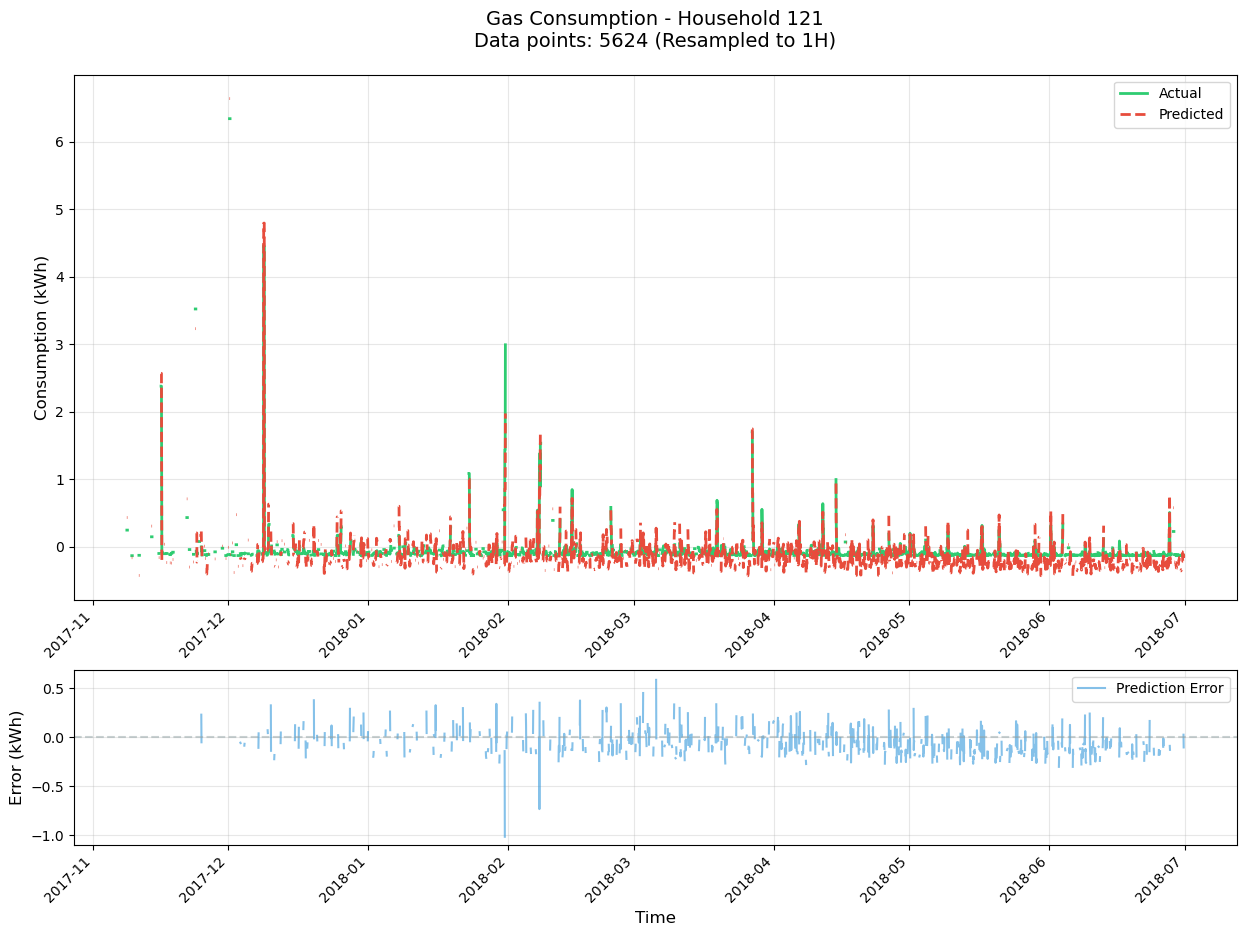

/var/folders/k4/dn8p6hf50m7bfl1db6pp0j0w0000gn/T/ipykernel_2352/4192286533.py:66: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data.resample(resample_rule).mean()


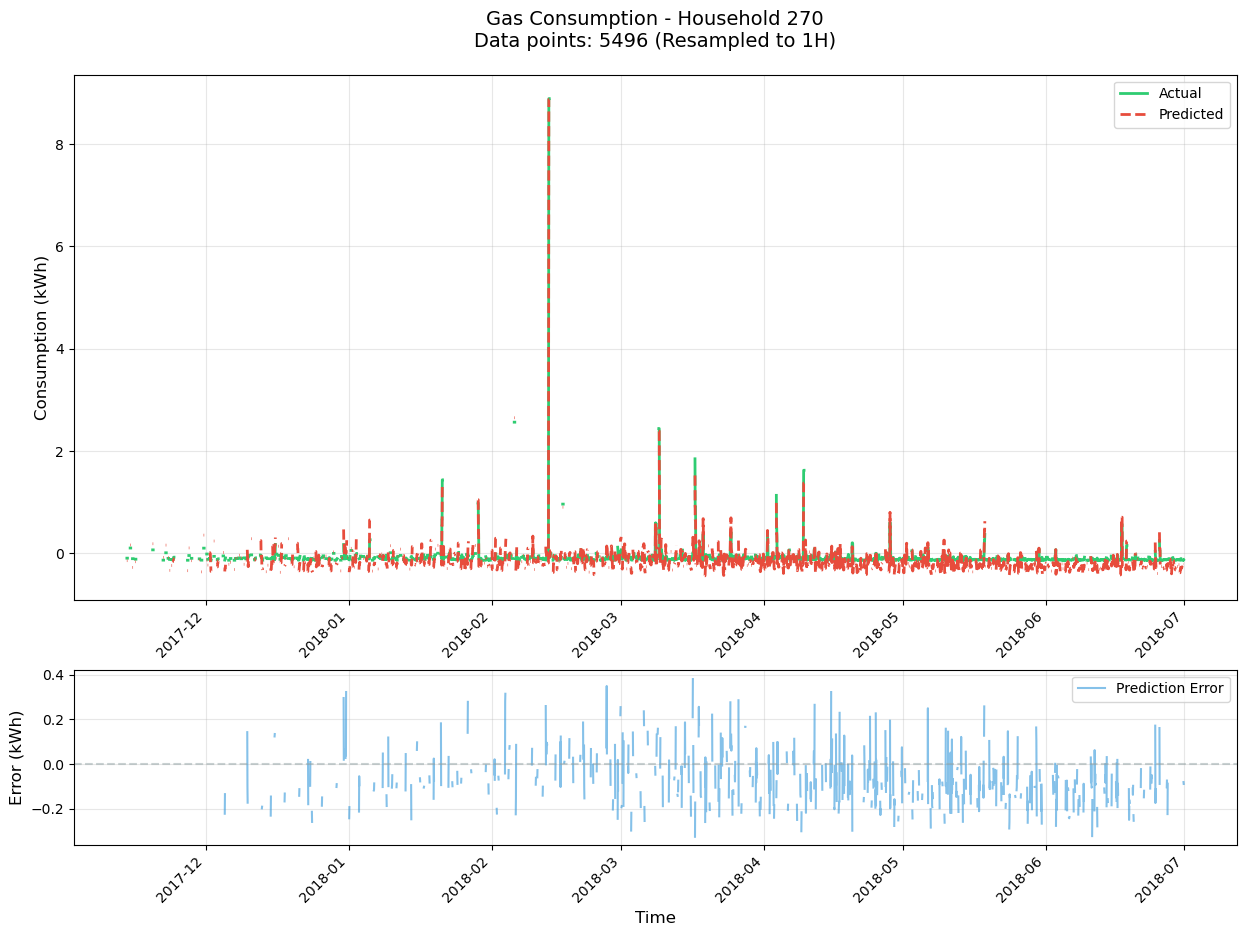

/var/folders/k4/dn8p6hf50m7bfl1db6pp0j0w0000gn/T/ipykernel_2352/4192286533.py:66: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data.resample(resample_rule).mean()


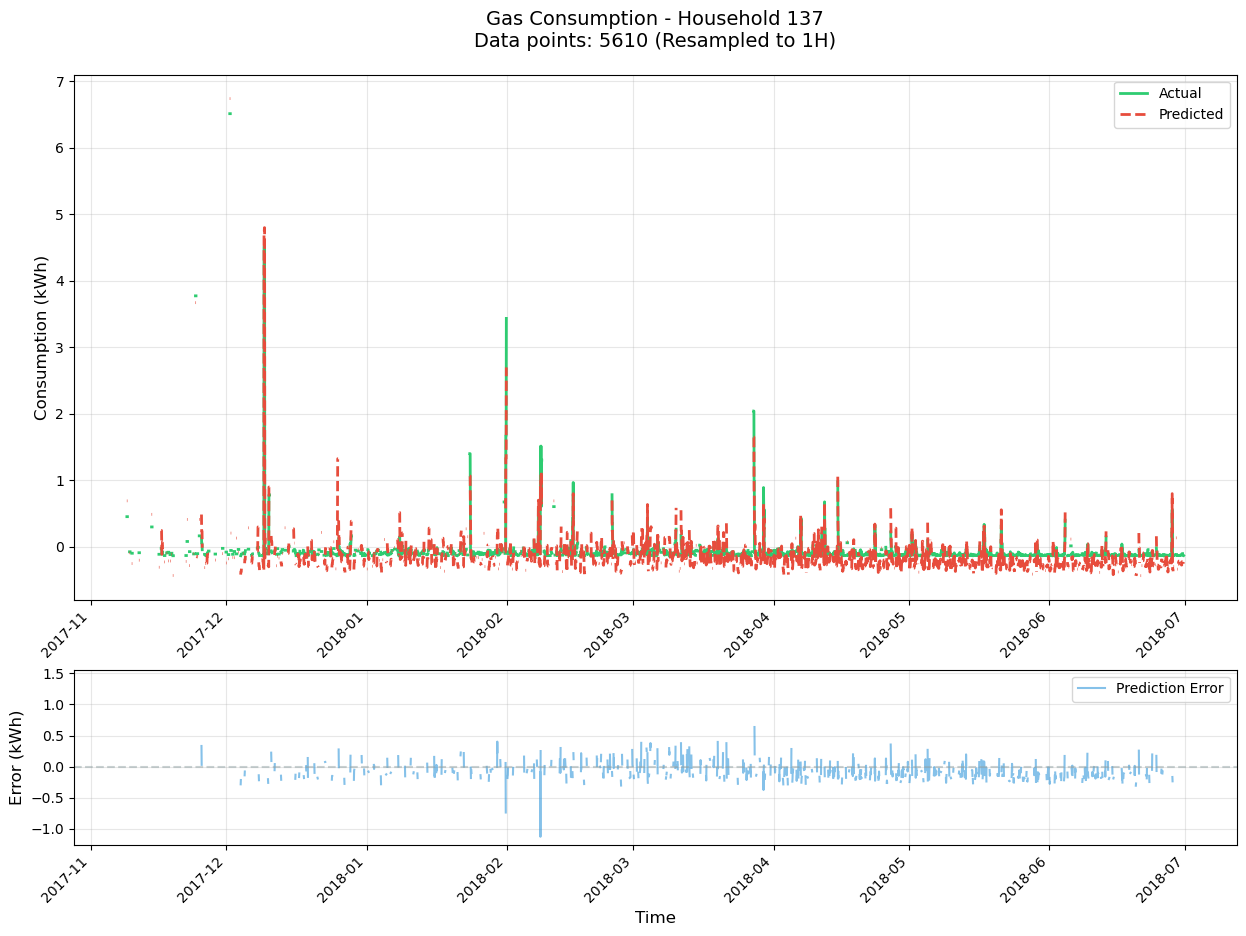

/var/folders/k4/dn8p6hf50m7bfl1db6pp0j0w0000gn/T/ipykernel_2352/4192286533.py:66: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data.resample(resample_rule).mean()


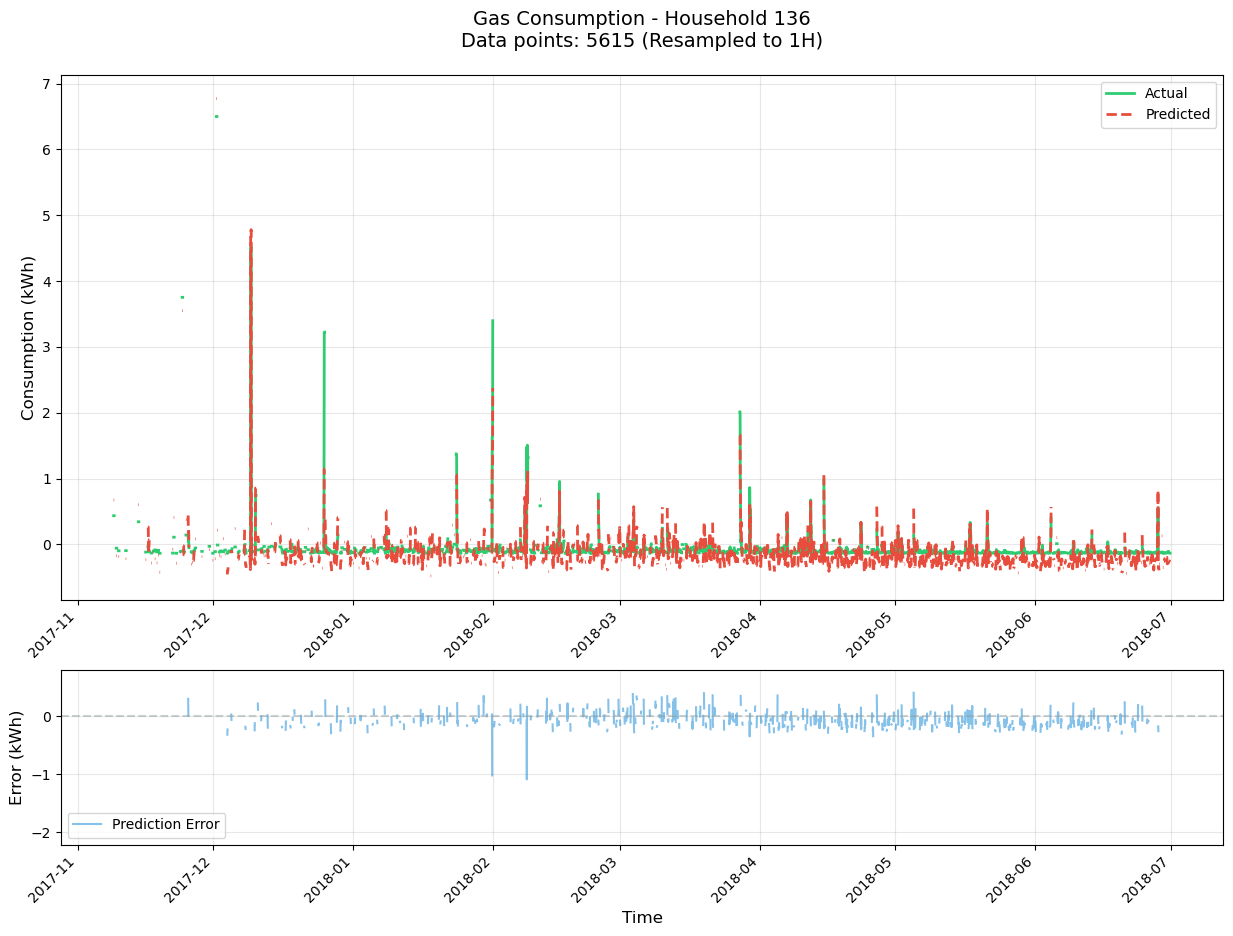

/var/folders/k4/dn8p6hf50m7bfl1db6pp0j0w0000gn/T/ipykernel_2352/4192286533.py:66: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data.resample(resample_rule).mean()


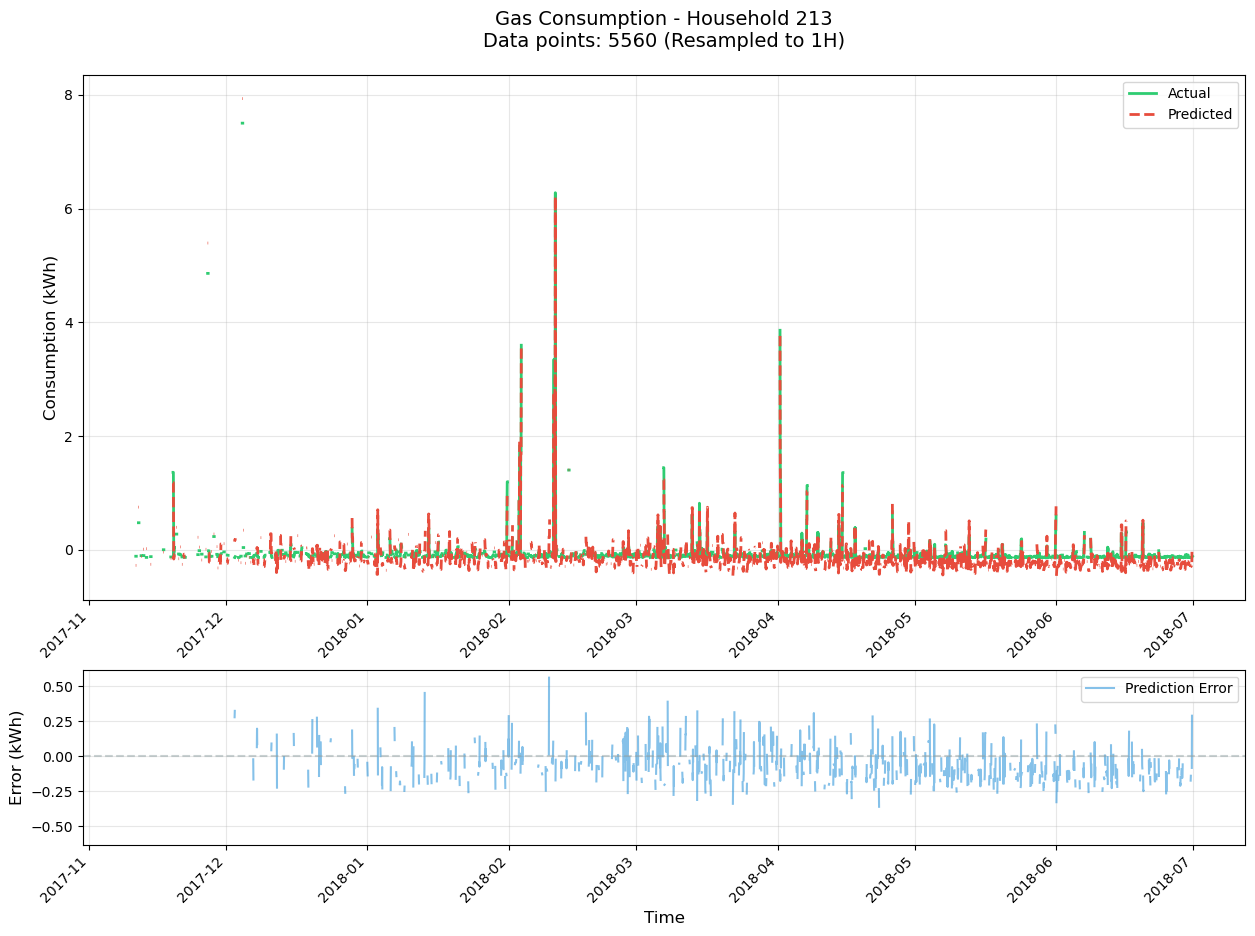

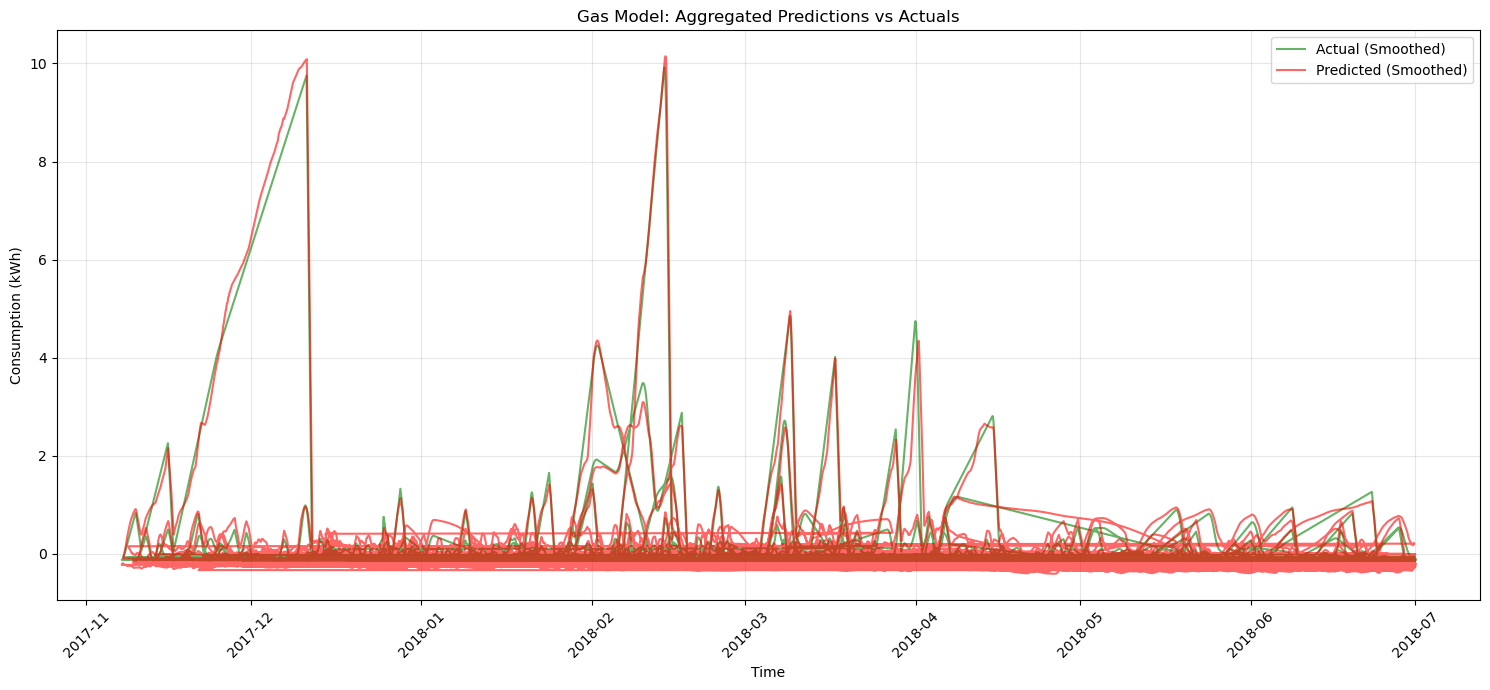

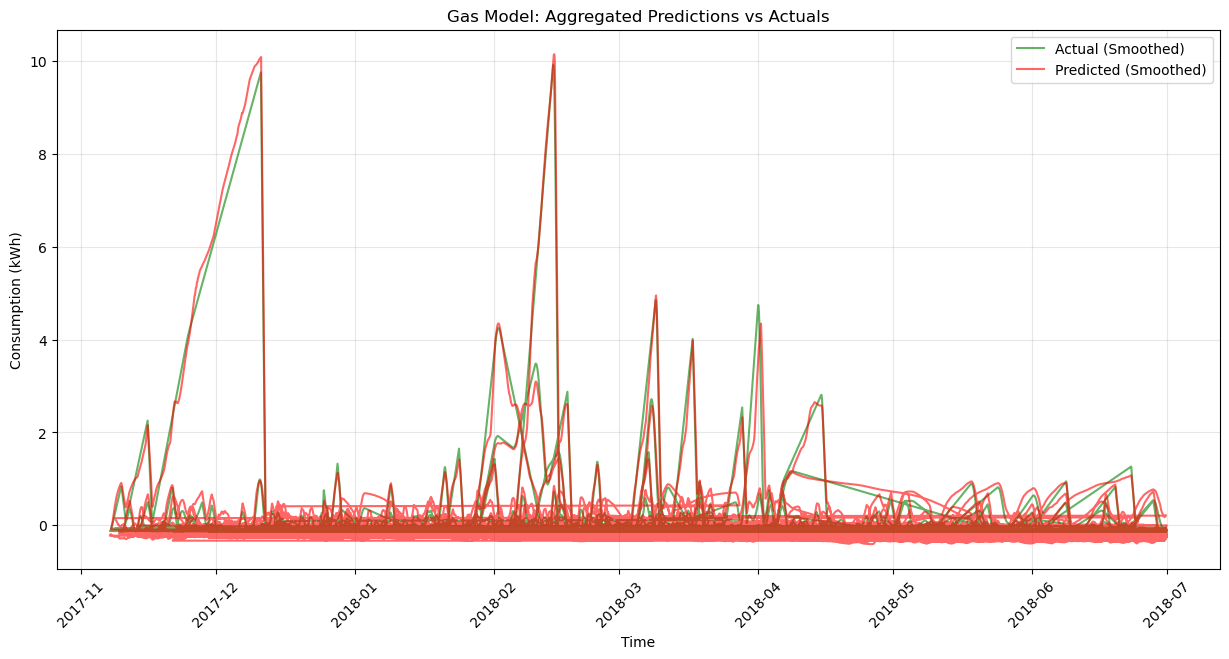

In [14]:
# Create plots
for name in results:
    plot_predictions_per_household(
        predictions=results[name]['predictions'],
        actuals=results[name]['actuals'],
        household_ids=metadata[name]['household_ids'],
        timestamps=metadata[name]['timestamps'],
        model_name=name,
        max_houses=5,
        show_plots=True
    )
    
    plt.figure(figsize=(15, 7))
    time_series = pd.to_datetime(metadata[name]['timestamps'])
    actual_series = pd.Series(results[name]['actuals'].flatten(), index=time_series)
    pred_series = pd.Series(results[name]['predictions'].flatten(), index=time_series)
    
    # Calculate rolling means with 24-hour window
    actual_smooth = actual_series.rolling(window=24, center=True, min_periods=1).mean()
    pred_smooth = pred_series.rolling(window=24, center=True, min_periods=1).mean()
    
    plt.plot(actual_smooth, label='Actual (Smoothed)', color='green', alpha=0.6)
    plt.plot(pred_smooth, label='Predicted (Smoothed)', color='red', alpha=0.6)
    
    plt.title(f'{name} Model: Aggregated Predictions vs Actuals')
    plt.xlabel('Time')
    plt.ylabel('Consumption (kWh)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    plot_predictions_aggregated(
        predictions=results[name]['predictions'],
        actuals=results[name]['actuals'],
        timestamps=metadata[name]['timestamps'],
        model_name=name,
        window_size=24,
        show_plots=True
    )

***SHAP Values***

In [15]:
# import shap



# def plot_shap_results(shap_values, X_sample, feature_names, model_name):
#     """
#     Plot SHAP results including summary and dependence plots
#     try:
#         # Create plots directory
#         plot_dir = Path('../reports/figures/shap')
#         plot_dir.mkdir(parents=True, exist_ok=True)
        
#         # Summary plot
#         plt.figure(figsize=(10, 8))
#         shap.summary_plot(shap_values, X_sample, feature_names=feature_names,
#                          show=False, plot_size=(10, 8))
#         plt.title(f'SHAP Summary Plot - {model_name} Model')
#         plt.tight_layout()
#         plt.savefig(plot_dir / f'{model_name.lower()}_shap_summary.png', 
#                    bbox_inches='tight', dpi=300)
#         plt.close()
        
#         # Feature importance plot
#         plt.figure(figsize=(10, 6))
#         shap.summary_plot(shap_values, X_sample, feature_names=feature_names,
#                          plot_type="bar", show=False)
#         plt.title(f'SHAP Feature Importance - {model_name} Model')
#         plt.tight_layout()
#         plt.savefig(plot_dir / f'{model_name.lower()}_shap_importance.png', 
#                    bbox_inches='tight', dpi=300)
#         plt.close()
        
#         # Dependence plots for top features
#         mean_shap_values = np.abs(shap_values).mean(0)
#         top_features_idx = mean_shap_values.argsort()[-5:][::-1]
        
#         for idx in top_features_idx:
#             plt.figure(figsize=(8, 6))
#             shap.dependence_plot(idx, shap_values, X_sample, 
#                                feature_names=feature_names, show=False)
#             plt.title(f'SHAP Dependence Plot - {feature_names[idx]}')
#             plt.tight_layout()
#             plt.savefig(plot_dir / f'{model_name.lower()}_shap_dependence_{feature_names[idx]}.png',
#                        bbox_inches='tight', dpi=300)
#             plt.close()
            
#     except Exception as e:
#         print(f"Error creating SHAP plots: {e}")

# def generate_shap_values(model, X_test, feature_columns, device, n_samples=500, background_size=100):
#     print("Preparing SHAP analysis...")
    
#     # Move model to CPU and set to eval mode
#     model = model.cpu()
#     model.eval()
    
#     # Calculate minimum required samples (features + buffer)
#     n_features = X_test.shape[1] * X_test.shape[2] if len(X_test.shape) == 3 else X_test.shape[1]
#     min_samples = n_features + 50  # Add buffer
    
#     # Adjust sample sizes if needed
#     n_samples = max(n_samples, min_samples)
#     background_size = max(background_size, min_samples // 2)
    
#     print(f"Using {n_samples} samples and {background_size} background samples")
    
#     # Reshape 3D input (samples, sequence_length, features) to 2D
#     if len(X_test.shape) == 3:
#         print(f"Reshaping input from {X_test.shape} to 2D...")
#         X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
#         feature_names = [f"{feat}_t{t}" 
#                         for feat in feature_columns 
#                         for t in range(X_test.shape[1])]
#     else:
#         X_test_reshaped = X_test
#         feature_names = feature_columns
    
#     def model_predict(x):
#         try:
#             # Reshape back to 3D for LSTM
#             if len(X_test.shape) == 3:
#                 x = x.reshape(-1, X_test.shape[1], X_test.shape[2])
            
#             # Convert to tensor and get predictions
#             x_tensor = torch.FloatTensor(x)
#             with torch.no_grad():
#                 return model(x_tensor).numpy()
#         except Exception as e:
#             print(f"Error in prediction: {e}")
#             return None

#     try:
#         # Select data subsets
#         background_data = X_test_reshaped[:background_size]
#         X_sample = X_test_reshaped[:n_samples]
        
#         # Estimate noise variance for LassoLarsIC
#         y_pred = model_predict(background_data)
#         noise_variance = np.var(y_pred)
        
#         print("Creating KernelExplainer...")
#         explainer = shap.KernelExplainer(
#             model_predict, 
#             background_data,
#             link="identity",
#             l1_reg="num_features(10)",
#             noise_level=noise_variance
#         )
        
#         print("Computing SHAP values...")
#         shap_values = explainer.shap_values(
#             X_sample, 
#             nsamples=200,  # Increased number of samples
#             l1_reg="num_features(10)"  # Regularization to handle high dimensionality
#         )
        
#         return shap_values, feature_names, X_sample
        
#     except Exception as e:
#         print(f"Error in SHAP analysis: {e}")
#         print(f"Error details: {str(e)}")
#         return None, None, None

# # Test with adjusted sample sizes
# print(f"X_test_gas shape: {X_test_gas.shape}")
# shap_values, features, X_sample = generate_shap_values(
#     model=model_gas,
#     X_test=X_test_gas,
#     feature_columns=feature_columns,
#     device=device
# )

# if shap_values is not None:
#     plot_shap_results(shap_values, X_sample, features, "Gas")
# else:
#     print("SHAP analysis failed. Unable to create visualizations.")